<a href="https://colab.research.google.com/github/JanTJung/recommender_system/blob/main/Research_papers_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of a research paper Recommender System

In this assignment, I built and test a research paper Recommender System. For this a *Collaborative Filtering* approach has been chosen.

The dataset comprises information about:

*   **Research papers**: The information of the research papers is stored in the *ResearchPapers.csv* file. 
*   **User rating**: The information about the ratings of the users. This information is stored the *UserInteractions.csv* file.

## Description of the files

The information about the research papers consists of:

*   **Id**: identifier of the research paper in the catalog. 
*   **Title**: Title of the research paperq
*   **Topic list**: a list of topics that describe the content of the paper
*   **Abstract**: The abstract of the paper (some papers may not have this information)

The information about the user ratings consists of:

*   **Id**: User Id
*   **Name**: Research paper id
*   **Session id**: Identifier of the session in which the rating was applied
*   **Rating**: The rateing given by the user to the book. This value is in a 1-4 scale.










In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -q surprise

     |████████████████████████████████| 11.8 MB 30.1 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import time
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict #data colector


import surprise #Surprise: https://surprise.readthedocs.io/en/stable/
from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate ##CrossValidation


##Matrix Factorization Algorithms
from surprise import SVD
from surprise import NMF

## Load the dataset



In [ ]:
# Define the path to the folder where the dataset is stored in
data_dir = 'drive/My Drive/Colab Notebooks/nlp-app-II/data/ResearchPapersDataset/'
user_interactions_file = data_dir + 'UserInteractions.csv'
paper_file_first = data_dir + 'ResearchPapers.csv'

## Preprocess the data

The data is given in two files. One contains the user_id, paper_id and the related rating. The second one contains informations about each paper.

To extract data from both files correctly, headers have to be added to the dataFrame first. 

In [ ]:
class PapersData:

    def __init__(self, paperFile):
        #self.tag_encoding = defaultdict()
        self.loadAndProcessData(paperFile)

    def loadAndProcessData(self, paperFile):
        paper_data = pd.read_csv(paperFile,on_bad_lines='skip')

        def cleanTitle(row):
            title = row['paper_Title']
            title = title[2:]
            disallowed_characters = "'"
            for character in disallowed_characters:
                title = title.replace(character, "")
            return title

        def cleanAbstract(row):
            abstract = row['abstract']
            abstract = abstract[2:]
            disallowed_characters = "'"
            for character in disallowed_characters:
                abstract = abstract.replace(character, "")
            return abstract
            

        def cleanId(row):
            iD = row['paper_Id']
            iD = iD[2:]
            disallowed_characters = "'"
            for character in disallowed_characters:
                iD = iD.replace(character, "")
            return iD

        def getYear(row):
            title = row['Paper_Title']
            yearPattern = re.compile(r"(?:\((\d{4})\))?\s*$")
            yearMatch = yearPattern.search(title)
            year = yearMatch.group(1)
            return year

        def topics_to_string(row):
            paper_Id = row['paper_Id']
            topics = row['topics']
            topics = topics[1:-1]
            disallowed_characters = " '"
            for character in disallowed_characters:
                topics = topics.replace(character, "")
            topics = ', '.join(g for g in topics.split(","))
            return topics

        #paper_data['year'] = paper_data.apply(getYear, axis = 1)
        paper_data['paper_Title'] = paper_data.apply(cleanTitle, axis = 1)
        paper_data['paper_Id'] = paper_data.apply(cleanId, axis=1)
        paper_data['abstract'] = paper_data.apply(cleanAbstract, axis=1)
        paper_data['representation'] = paper_data.apply(topics_to_string, axis = 1)

        ## Remove unnecesary columns
        paper_data.drop('topics', axis='columns', inplace=True)

        self.paper_data = paper_data

        self.paper2idx = pd.Series(paper_data.index, index=paper_data['paper_Id'])
        self.paperIds = np.unique(paper_data['paper_Id'])

    def getPaperIds(self):
        return self.paperIds

    def getPaperIdx(self, paperId):
        idx = self.paper2idx[paperId]
        if type(idx) == pd.Series:
            idx = idx.iloc[0]
        return idx

    def getPaperRepresentations(self):
        return self.paper_data['representation']

    def getPaperInfo(self, paperId):
        idx = self.getPaperIdx(paperId)
        paper = self.paper_data.iloc[idx]

        return {'paper_Id': paper['paper_Id'],
                'title': paper['title'],
                'year': paper['year']}

As the dataset with 1,7 Mio reviews is very big, df_1 can be reduced. The big downside is that the results are worse, but it's a good way to see the functionality of the notebook.

In [ ]:
#Ratings are loaded
df_1 = pd.read_csv(user_interactions_file, header=None, sep=';', on_bad_lines='skip')
df_1.to_csv("user_interactions_file.csv", header=["user_Id", "time_Stamp", "session_Id", "paper_Id", "rating"], index=False) # Add header to file
df_1 = pd.read_csv("user_interactions_file.csv")
#df_1 = df_1[:10000] #Uncomment to reduce dataset size
def id_Clean(iD):
  return (iD[2:]).replace("'", "") #replace quotes from strings

df_1['paper_Id'] = df_1['paper_Id'].apply(id_Clean)
  

In [ ]:
#Paper Files are loaded
df_2 = pd.read_csv(paper_file_first, header=None, sep=';', on_bad_lines='skip')
df_2.to_csv("paper_file.csv", header=["paper_Id", "paper_Title", "topics", "abstract"], index=False) #Add header to file

paper_file = "paper_file.csv"
paperData = PapersData(paper_file) #file is preprocessed with class functions

In [ ]:

d_1 = {'user_Id': df_1['user_Id'],
       'paper_Id': df_1['paper_Id'],
       'rating': df_1['rating']}

d_2 = {'paper_Title': paperData.paper_data['paper_Title'],
       'paper_Id': paperData.paper_data['paper_Id'],
       'representation': paperData.paper_data['representation']}

#Data load into panda DataFrame
ratings_df = pd.DataFrame(data=d_1)
papers_df = pd.DataFrame(data=d_2)


In [ ]:
ratings_df.head()
ratings_df.info()
ratings_df.describe()
papers_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741339 entries, 0 to 1741338
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_Id   object
 1   paper_Id  object
 2   rating    int64 
dtypes: int64(1), object(2)
memory usage: 39.9+ MB


,paper_Title,paper_Id,representation
0,Construction of an Idiom Corpus and its Applic...,4c3535d8d8993c53ab5913f37c96a6c9688dd431,"climateforecastsystem, language-independentspe..."
1,A Review on Word Sense Disambiguation,3296752a29c83380219e4fa85e90d7310265f548,"dictionary[publicationtype], informationretrie..."
2,Why Build Another Part-of-Speech Tagger ? A Mi...,1dee505b260b59edbd9bac4bc29e85a1d4c4f908,"acquiredimmunodeficiencysyndrome, algorithm, a..."
3,A Case Study On Inter-Annotator Agreement For ...,ac20da2a10ef8b07679c8dc951ed342b704a72fd,"bodyofuterus, browncorpus, class, computer, co..."
4,HLT-NAACL 2007 TextGraphs-2 : Graph-Based Algo...,12d8236671771531fbef46a052c7c9f57389107e,"algorithm, data(computing), directedgraph, dis..."


**To improve performance bad users or papers can be erased from the dataset.**

*min_paper_ratings* decribes the min value of ratings a paper has to have

*min_user_ratings* decribes the min value of ratings a user had to do

In [ ]:
min_paper_ratings = 0 #a paper was rated at least that often
min_user_ratings =  0 #a user rated at least that many papers

ratings_flrd_df = ratings_df.groupby("paper_Id").filter(lambda x: x['paper_Id'].count() >= min_paper_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("user_Id").filter(lambda x: x['user_Id'].count() >= min_user_ratings)


print("{0} papers deleted; all papers are now rated at least: {1} times. Old dimensions: {2}; New dimensions: {3}"\
.format(len(ratings_df.paper_Id.value_counts()) - len(ratings_flrd_df.paper_Id.value_counts()),\
        min_paper_ratings,ratings_df.shape, ratings_flrd_df.shape ))

reader = Reader(rating_scale=(1, 4)) #gives the range of possible ratings
data = Dataset.load_from_df(ratings_flrd_df[["user_Id",	"paper_Id",	"rating"]], reader=reader)



0 papers deleted; all papers are now rated at least: 0 times. Old dimensions: (1741339, 3); New dimensions: (1741339, 3)


Create the train and testset

In [ ]:
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

## Implementation of the algorithm

Following the algorithm is created, for which a Singular Value Decomposition has been chosen. As the RSME increases with too many cycles and runtime is very high, small number of itterations is recommended.

In [ ]:
def rmse_vs_factors(algorithm, data):
  """
  Returns: rmse_algorithm i.e. a list of mean RMSE of CV = 5 in cross_validate() for each factor k in range
  Arg:  
  i.) algorithm = Matrix factoization algorithm, e.g SVD/NMF/PMF, 
  ii.)  data = surprise.dataset.DatasetAutoFolds
  """

  rmse_algorithm = []

  for k in range(1, 3, 1): # numbers of itterations. As the RMSE goes up over time, not many itterations are necessary. Furthermore, runtime it very high

    start = time.time()

    algo = algorithm(n_factors=k)
    # ["test_rmse"] is numpy array with min accuracy value for each testset
    loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean()
    rmse_algorithm.append(loss_fce)

    end = time.time()
    print(end - start)
          
  return rmse_algorithm

rmse_svd = rmse_vs_factors(SVD,data)
print(rmse_svd)

173.6892819404602
186.0066568851471
[0.022081593121133954, 0.022105718465230104]


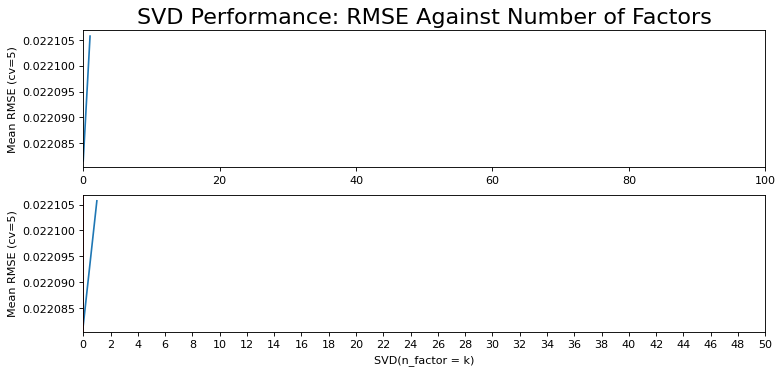

In [ ]:
def plot_rmse(rmse, algorithm):
    """
    Returns: sub plots (2x1) of rmse against number of factors.
      Vertical line in the second subplot identifies the arg for minimum RMSE

    Arg: 
    i.) rmse = list of mean RMSE returned by rmse_vs_factors() 
    ii.) algorithm = string of algo
    """

    plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

    plt.subplot(2, 1, 1)
    plt.plot(rmse)
    plt.xlim(0, 100)
    plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size=20)
    plt.ylabel("Mean RMSE (cv=5)")

    plt.subplot(2, 1, 2)
    plt.plot(rmse)
    plt.xlim(0, 50)
    plt.xticks(np.arange(0, 52, step=2))

    plt.xlabel("{0}(n_factor = k)".format(algorithm))
    plt.ylabel("Mean RMSE (cv=5)")
    plt.axvline(np.argmin(rmse), color="r")
    plt.show()

plot_rmse(rmse_svd,"SVD")

Following the best numbers of factors are determined.

In [ ]:
#param_grid = {'n_factors': [20,40,60,80,100,120,140]}
param_grid = {'n_factors': [20]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])
#4 is the best one



0.02241352458987899
{'n_factors': 20}


After testing the values [20,40,60,80,100,120,140], the result was that 20 factors is the best combination.

In [ ]:
algo_SVD = SVD(n_factors = 100) # I tried 100 to check manually if the results are better
algo_SVD.fit(trainset)


# Predict ratings for all pairs (i,j) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions = algo_SVD.test(testset)

# subset of the list predictions
print(predictions[0:2])

[Prediction(uid='NLP_1878', iid='1d120d28b8bfd89e0d673900201bc8ba45b94407', r_ui=2.4997177459414854, est=3.9687885244458583, details={'was_impossible': False}), Prediction(uid='NLP_1878', iid='dc88ac9aee3cf09ae5c1fa417e72ea204c429092', r_ui=2.4997177459414854, est=3.97261522521449, details={'was_impossible': False})]


As prediction for a Dataset with 1.7 million ratings take very long, saving the predictions is a very good idea


In [ ]:
"""with open("predictions_file", "wb") as fp:   #Pickling
  pickle.dump(predictions, fp)

with open("predictions_file", "rb") as fp:   # Unpickling
  predictions = pickle.load(fp)"""

'with open("predictions_file", "wb") as fp:   #Pickling\n  pickle.dump(predictions, fp)\n\nwith open("predictions_file", "rb") as fp:   # Unpickling\n  predictions = pickle.load(fp)'

In [ ]:
def get_top_n(predictions, user_Id, papers_df, ratings_df, n=10):
    '''
    Returns the top N (default = 10) paper_Id for a user and his history for comparison
    
    '''

    # 1. First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # 2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[: n]

    # Part II.: inspired by: https://beckernick.github.io/matrix-factorization-recommender/

    # 3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.user_Id == (user_Id)]
    print('User {0} has already rated {1} papers.'.format(user_Id, user_data.shape[0]))

    # 4. Data Frame with predictions.
    preds_df = pd.DataFrame([(id, pair[0], pair[1]) for id, row in top_n.items() for pair in row],
                            columns=["user_Id", "paper_Id", "rat_pred"])
    

    pred_usr = preds_df[preds_df["user_Id"] == (user_Id)]
    hist_usr = ratings_df[ratings_df.user_Id == (user_Id)]

    pred_usr.drop(pred_usr.index[pred_usr['user_Id'] != user_Id], inplace=True)
    pred_usr["paper_Title"] = np.nan
    pred_usr["interests"] = np.nan

    hist_usr.drop(hist_usr.index[hist_usr['user_Id'] != user_Id], inplace=True)
    hist_usr["paper_Title"] = np.nan
    hist_usr["interests"] = np.nan

    pred_usr = pred_usr.reset_index(drop=True)

    
    def copy_pred(x):

      index = (pred_usr.loc[pred_usr['paper_Id'] == x])['paper_Title'].index.values.astype(int)[0]
      pred_usr['paper_Title'][index] = (papers_df.loc[papers_df['paper_Id'] == x])['paper_Title'].values
      pred_usr['interests'][index] = (papers_df.loc[papers_df['paper_Id'] == x])['representation'].values

    def copy_hist(x):

      index = (hist_usr.loc[hist_usr['paper_Id'] == x])['paper_Title'].index.values.astype(int)[0]
      hist_usr['paper_Title'][index] = (papers_df.loc[papers_df['paper_Id'] == x])['paper_Title'].values
      hist_usr['interests'][index] = (papers_df.loc[papers_df['paper_Id'] == x])['representation'].values

    pred_usr['paper_Id'].apply(copy_pred)
    hist_usr['paper_Id'].apply(copy_hist)
    
    return pred_usr, hist_usr

In [ ]:
user_Id = 'NLP_1878'
pred, hist = get_top_n(predictions, papers_df = papers_df, user_Id = user_Id, ratings_df = ratings_df)
pred


User NLP_1878 has already rated 258 papers.


,user_Id,paper_Id,rat_pred,paper_Title,interests
0,NLP_1878,b140da8cfdc3a801ba37c64ce00a9f1252146a10,3.980937,[Effects of long-term amiodarone therapy on th...,"[amiodarone, anti-arrhythmiaagents, arteriopat..."
1,NLP_1878,12f17c64eb20f051552295d2c928f036f5b8163b,3.980795,[On the Use of Automatically Acquired Examples...,"[algorithm, expertsystem, heuristic(computersc..."
2,NLP_1878,d31a79b28cfb7736d561f822cd333a6397fe928f,3.980774,[Measuring Word Meaning in Context],"[cognition, computation, computationallinguist..."
3,NLP_1878,41af3e7e5bdc352ca780e5f6853d7b94113f4e1b,3.980490,[Why chronic obstructive pulmonary disease pat...,"[airwayobstruction, airwaystructure, cardiomyo..."
4,NLP_1878,73d24d4756eddf672304c83a1efe2470b6af6fd7,3.979886,[An Assessment of Time Dependence of Defibrill...,"[101mouse, ace, angiotensinreceptorantagonists..."
5,NLP_1878,bf9cdbdf745787f3ce605bf2b57f0f78cebafd23,3.979787,[Catadioptric Stereo with Planar Mirrors : Mul...,"[algorithm, calibration, computervision, echo-..."
6,NLP_1878,7d505dae323accc6ebd5950a748e730378300d57,3.978547,[Inhaled corticosteroids and chronic obstructi...,"[adrenalcortexhormones, airwayobstruction, air..."
7,NLP_1878,974503fba2c3d7e8b935711cb70edd3c9044b8c9,3.978095,[[Pulmonary function results in healthy subjec...,"[airwayobstruction, airwaystructure, chest, ch..."
8,NLP_1878,6913bc3cd9258fbcbb199f2581d42d5ce2f773b1,3.978004,[Chronic obstructive pulmonary disease: a defi...,"[airwayobstruction, airwaystructure, bronchi, ..."
9,NLP_1878,a774a1968aa3bffed25ccb9593af9233d2ff07ad,3.977887,[LV Dyssynchrony Is Helpful in Predicting Vent...,"[areaundercurve, arteriopathicdisease, cardiac..."


In [ ]:
user_Id = 'RE_990'
pred, hist = get_top_n(predictions, papers_df = papers_df, user_Id = user_Id, ratings_df = ratings_df)

pred

User RE_990 has already rated 243 papers.


,user_Id,paper_Id,rat_pred,paper_Title,interests
0,RE_990,ae938972dd2bad12741ff2cc82d83925628ac167,3.980111,[Safety and effectiveness of the high-frequenc...,"[airwayobstruction, airwaystructure, analysiso..."
1,RE_990,60f22ad00727252cda1c0d365365685c90db47c6,3.978901,[Roles of sigma-1 receptors in Alzheimers dise...,"[abnormaldegeneration, ""alzheimersdisease"", am..."
2,RE_990,8454b18a347d77d486a22fb69ec9cc397b99215d,3.978816,[A Thesis in Partial Fulfilment of the Require...,"[baseline(configurationmanagement), bodyofuter..."
3,RE_990,0dcc3d82f623a2bfd8604c25c69bc0dd0b2d550d,3.978594,[Role of Traditional Heart Failure Medications...,"[ace, adrenergicbeta-antagonists, aldosterone,..."
4,RE_990,67257ab576a6e86dcd60b9159327f4ea3f64e964,3.977692,[PLGA nanoparticles modified with a BBB-penetr...,"[""alzheimersdisease"", amyloidbeta-peptides, bl..."
5,RE_990,06b3d05599aace7f439c787cc6a174a50918b5b6,3.977295,[Significant differences in flow standardised ...,"[airwayobstruction, airwaystructure, asthma, b..."
6,RE_990,114acf554a00079e5174926d84421c490d2aa85d,3.976825,[Ibuprofen ameliorates protein aggregation and...,"[""alzheimersdisease"", animalmodel, animals, tr..."
7,RE_990,23a5ea41f9b6439435bfdc58dc1097ad842ce1c9,3.976719,[ACP Journal Club. Review: Adding tiotropium t...,"[adrenalcortexhormones, adverseevent, airwayst..."
8,RE_990,a854884cbf76e5e6523cdbab6df7ea7742e8dae0,3.976700,"[Circadian variation of arrhythmic events, ele...","[autonomicnervoussystem, bloodplatelets, cnsdi..."
9,RE_990,291c47c7439c064aa9c33d3f0b3dbde756e6611d,3.976611,[THE THALAMUS IN PARKINSON\xe2\x80\x99S DISEAS...,"[acousticlobing, ""alzheimersdisease"", atrophic..."


In [ ]:
user_Id = 'NLP_1267'
pred, hist = get_top_n(predictions, papers_df = papers_df, user_Id = user_Id, ratings_df = ratings_df)

pred

User NLP_1267 has already rated 255 papers.


,user_Id,paper_Id,rat_pred,paper_Title,interests
0,NLP_1267,6c7117df0786000736c95a6d6cabcb167e92136c,3.988617,[Social and psychosocial influences on sudden ...,"[anxietydisorders, arteriopathicdisease, cardi..."
1,NLP_1267,cee783bd1aa4a7b32c03169f95e687741285899b,3.986034,[Sudden cardiac death in athletes.],"[arteriopathicdisease, atherosclerosis, cardio..."
2,NLP_1267,18070803607e2d2928f4a3645d662a3a548b74b8,3.985023,[ICDs for secondary prevention of sudden death...,"[aging, amiodarone, anti-arrhythmiaagents, art..."
3,NLP_1267,d60709e1ffa840eab5bb46190eeba7719e42f0e0,3.982960,[Valvular disease: The MitraClip\xc2\xae in hi...,"[anginapectoris, arteriopathicdisease, cardiac..."
4,NLP_1267,4e09bf7a02332f26ab9ce427864c71ea8f693b3b,3.982716,[Nonlinear dynamics of heart rhythm disorders],"[artificialcardiacpacemaker, asynchrony(comput..."
5,NLP_1267,00117a0edef9969cab1adbb1ce6a6193c81fc419,3.981970,[Research Statement],"[approximationalgorithm, artificialintelligenc..."
6,NLP_1267,278ce69a1b1d3b64552f423d814c4e3b5bb2afe0,3.981632,[T wave alternans for ventricular arrhythmia r...,"[arteriopathicdisease, cardiomyopathies, cardi..."
7,NLP_1267,2c91c1c2afa5a2147968f20f270c4abfc672fd71,3.981370,[Applications of Computer Vision in Space Robo...,"[automation, capabilitymaturitymodel, computer..."
8,NLP_1267,f2f7007c677c7ca12edc51fcb2bbc7423f5fd21a,3.981307,[Tiotropium bromide: a novel once-daily antich...,"[adverseevent, affinity, airwayobstruction, an..."
9,NLP_1267,7ea89e6c3a43c00e0fa469c031eab4c41515bc65,3.981238,[[The neuropathology of sleep in human neurode...,"[abducensnervediseases, abnormaldegeneration, ..."


### Describe why you chosed the evaluation procedure you implemented

I chose Collaborative Model-based Filtering, as I wanted to see a new approach that is also used in daily life.

Content based filtering normally outperforms collaborative filtering, as the recomendations are based on metadata which the user prefers (genres etc.) However, this leads to recommendations only in a bubble.

Collaborative Filtering, especially model based, was originally developed by Amazon and is currently adopted by most online corporations (e.g. Netflix, YouTube, etc.).

To see that approach and its implementation I chose this method. 

## Get and compare the recommendations for users **NLP_1267** and **RE_990**

**How do they look?** 

Both users got recomendations different to their current taste. While NLP_1267 was reading more Natural Language Processing papers, it now gets recommended a lot of Biomedical papers. There is a correlation between medical papers and NLP, as NLP is used in that field. Unfortunatelly user RE_990 also gets recommended a lot of medical papers, which means that probably the amount of data is not enough for the model to infer the preferences.

Second approach to increase the number of factors also didnt bring better results

**Are they appropriate?** 

I cant tell if the recommendations are appropriate or not, as I dont know the papers specifically. For NLP users medical papers are appropriate, and they get a good mixture of Computer science and medical papers. However, the results for the RE user dont seem to fit very well.


**Would you prefer more diversity?**
The diversity for NLP users seem to be good, while diversity for RE users might be too high. Here some influence from the metadata (genre) of the papers would have been helpful. Therefore a mixture of Collaborative and Content based filtering would be a good idea.

**Addition**
I checked several numbers of factors and see manually if the papers got better. I noticed slight changes in the papers for NLP users, as they get a bit more computer science papers. Unfortunatelly, the results for RE users continue to stay in the medical area.